In [1]:
import pystan
import numpy as np 
import pandas as pd
import matplotlib
import scipy
from sklearn import preprocessing, datasets, linear_model, metrics


In [3]:
real_data = pd.read_csv('hole_data_2018_f.csv')
real_data.head(10)

,perm_tourn,player,course,course_name,player_full,hole,round,score,tourn_name,par
0,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",1,1,4,Safeway Open,4
1,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",2,1,3,Safeway Open,3
2,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",3,1,4,Safeway Open,4
3,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",4,1,4,Safeway Open,4
4,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",5,1,4,Safeway Open,5
5,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",6,1,4,Safeway Open,4
6,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",7,1,3,Safeway Open,3
7,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",8,1,5,Safeway Open,4
8,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",9,1,4,Safeway Open,5
9,464,1810,552,Silverado Resort and Spa North,"Mickelson, Phil",10,1,3,Safeway Open,4


In [65]:
np.random.seed(999)
TOTAL_SCORES = 200
avg = 295 	# tour average drive
total_players = 8
total_holes = 15

prcnt_topplyrs_hardhole = 0.7 # for a hard hole (i.e. top 33% of holes) what percent of top players (top 50%) saturate the data 
prcnt_topplyrs_medhole = 0.4 # same as above for medium
prcnt_topplyrs_easyhole = 0.3 # same as above for easy
prcnt_hard_holes = .3 # what percent of the total shots are at hard holes
prcnt_med_holes = .3 # same as above for medium holes
prcnt_easy_holes = .4 # same as above for easy holes

a = np.random.normal(4, 1, size = total_holes)
a = np.sort(a)[::-1]
#print(a)
x = np.random.normal(0, 1, size= total_players)
b = np.random.normal(.2, .2, size = total_holes)
x = np.sort(x)[::-1]
#print(x)
error = np.random.normal(0,.005, size = TOTAL_SCORES)

plist = np.array([f'Player {i}' for i in range(total_players)]).tolist()
pld = {'Player': plist, 'x_std': x}
pDF = pd.DataFrame(pld, columns=['Player', 'x_std'])		# player DF includes player name and true value to refer back to later
pDF.set_index('Player', inplace = True)	

hlist = np.array([f'Hole {i}' for i in range(total_holes)]).tolist()
hld = {'Hole': hlist, 'h_avg': a, 'h_dsr': b}
hDF = pd.DataFrame(hld, columns=['Hole','h_avg','h_dsr'])		# hole DF includes hole name and true value to refer back to later
hDF.set_index('Hole', inplace = True)

#print(hDF)
#print(hDF)

In [66]:
def convert_to_avg(players, holes):	# takes player and hole name vectors as input and returns matching true value vectors
    pscore = []
    dscore = []
    hscore = []
    for player in players:
        pscore.append(pDF.loc[player, 'x_std'])
    for hole in holes:
        hscore.append(hDF.loc[hole, 'h_avg'])
        dscore.append(hDF.loc[hole, 'h_dsr'])
    pvect = np.asarray(pscore)
    dvect = np.asarray(dscore)
    hvect = np.asarray(hscore)
    return pvect, hvect, dvect


def calc_holes(difficulty, nholes): # used this to fix problem of uniform distribution across holes and players
    if difficulty == 'hard':		# given adjustable parameters at top, calculates a semi-realistic scenario for hole and player distributions
        mix = prcnt_topplyrs_hardhole
        holebydif = hld['Hole'][(round(total_holes*0/3)):(round(total_holes*1/3))]  
    elif difficulty == 'medium':
        mix = prcnt_topplyrs_medhole
        holebydif = hld['Hole'][(round(total_holes*1/3)):(round(total_holes*2/3))]
    elif difficulty == 'easy':
        mix = prcnt_topplyrs_easyhole
        holebydif = hld['Hole'][(round(total_holes*2/3)):(round(total_holes*3/3))+1]
    else: return '\nerror\n'

    topplyrs = np.random.choice(pld['Player'][-(round(total_players/2)):], round(mix*nholes)) # takes random player from top half for the percent top players of each hole
    botplyrs = np.random.choice(pld['Player'][:round(total_players/2)+1], round(nholes-(mix*nholes))) # takes random player from bottom half for the rest of the holes played
    plyrs = np.append(topplyrs, botplyrs) # each player added is a shot
    hls = np.random.choice(holebydif, nholes) # random selection of holes in certain category. each selection is a shot

    return plyrs, hls 	# plyrs and hls are same length. Length is equivalent to the amount of shots we want to create


def mainFun(totalscores, hardholes, medholes, easyholes): # choose how many total shots to create data frame (i.e. rows) and % of each type of hole
    hard = round(totalscores*hardholes) # number of hard holes
    med = round(totalscores*medholes)	# number of med holes
    easy = round(totalscores*easyholes)	# number of easy holes
    
    p1, h1 = calc_holes('hard', hard) # returns hard many shots on hard holes
    p2, h2 = calc_holes('medium', med)
    p3, h3 = calc_holes('easy', easy)
    
    p4 = np.append(p1,p2)
    p = np.append(p4,p3) # length of p will be how many shots the data frame is = totalshots

    h4 = np.append(h1,h2)
    h = np.append(h4,h3) # length of h will be how many shots the data frame is = totalshots
    
    return p, h, hard, med, easy

In [67]:
plyrvector, holevector, h, m,e = mainFun(TOTAL_SCORES, prcnt_hard_holes, prcnt_med_holes, prcnt_easy_holes) # putting into a dataframe 
pavgvector, havgvector, dsrvector = convert_to_avg(plyrvector, holevector) # takes player name and hole name to return pavg, havg in order to calculate distance (hidden layers)
scorevector = havgvector - pavgvector*dsrvector + error   # calculates "actual distance" for synthetic data

maindf = pd.DataFrame({'Score':scorevector, 'Player': plyrvector, 'Hole': holevector, 'P_avg': pavgvector, 'dsr': dsrvector, 'H_avg': havgvector, 'Error': error})

In [68]:
#print(maindf.head(10))
#le1 = preprocessing.LabelEncoder()
#print(maindf['Player'].head(10))
print(maindf['Score'].head(10))
plyr_data = maindf['Player'].map(lambda x: int(x.lstrip('Player ')))
#fake_players = le1.fit_transform(plyr_data)
#print(fake_players)
hole_data = maindf['Hole'].map(lambda x: int(x.lstrip('Hole ')))
#print(hole_data)
#fake_holes = le1.fit_transform(hole_data)
#print(fake_holes)

0    5.486040
1    5.484174
2    4.170778
3    5.478738
4    4.191570
5    4.174099
6    5.870327
7    5.922397
8    5.127296
9    5.875371
Name: Score, dtype: float64


In [4]:
le = preprocessing.LabelEncoder()
players = le.fit_transform(real_data['player'])
#print(real_data['player'])
#print(players)
real_data['hole_id'] = real_data['course'].map(str) + '_' + real_data['hole'].map(str)
real_data.head(10)
holes = le.fit_transform(real_data['hole_id'])
#print(len(np.unique(real_data['player'])))
#print(len(np.unique(players)))

In [5]:
# exact model -sigvector from Stephen Jesse paper
# this one working 

fake_code = """
data {
  int<lower=0> N;
  int<lower=0> nplayers;
  int<lower=0> nholes;
  vector[N] y;
  int<lower=1, upper=nplayers> playerid[N];
  int<lower=1, upper=nholes> holeid[N];
}
parameters {
    vector[nplayers] x;
    vector[nholes] alpha;
    vector[nholes] beta;
    real<lower=0> sigma;
    
}
transformed parameters {
    vector[N] y_hat;
    real xmean;
    real xsd;
    real amean;
    real asd;
    real bmean;
    real bsd;
    
    xmean = mean(x);
    xsd = sd(x);
    
    amean = mean(alpha);
    asd = sd(alpha);
    
    bmean = mean(beta);
    bsd = sd(beta);
    
    for (i in 1:N){
        y_hat[i] = alpha[holeid[i]] - beta[holeid[i]]*x[playerid[i]];   
    }
}

model {
    sigma ~ normal(0,1);
    y ~ normal(y_hat, sigma);
    x ~ normal(0, 1);
    alpha ~ normal(3, 1);
    beta ~ normal(0, 1);
    
}
"""

In [7]:
# exact model -sigvector from Stephen Jesse paper
# this one working 

steph_code = """
data {
  int<lower=0> N;
  int<lower=0> nplayers;
  int<lower=0> nholes;
  vector[N] y;
  int<lower=1, upper=nplayers> playerid[N];
  int<lower=1, upper=nholes> holeid[N];
}
parameters {
    vector[nplayers] xU;
    vector[nholes] alphaU;
    vector[nholes] betaU;
    real<lower=0> sigma;
    
}
transformed parameters {
    vector[N] y_hat;
    vector[nplayers] x;
    vector[nholes] alpha;
    vector[nholes] beta;
    real xmean;
    real xsd;
    real aUmean;
    real aUsd;
    real bUmean;
    real bUsd;
    real amean;
    real asd;
    real bmean;
    real bsd;
    
    
    xmean = mean(xU);
    xsd = sd(xU);
    
    aUmean = mean(alphaU);
    aUsd = sd(alphaU);
    
    bUmean = mean(betaU);
    bUsd = sd(betaU);
    
    for (i in 1:N){
        y_hat[i] = alphaU[holeid[i]] - betaU[holeid[i]]*xU[playerid[i]];
        
    }
    
    for(i in 1:nplayers){
        x[i] = (xU[i] - xmean) / xsd;
   }

    for (j in 1:nholes){
        alpha[j] = alphaU[j] + xmean*betaU[j];
        beta[j] = betaU[j]*xsd;
    }
    
    amean = mean(alpha);
    asd = sd(alpha);
    
    bmean = mean(beta);
    bsd = sd(beta);
    
}

model {
    sigma ~ normal(0,0.5);
    y ~ normal(y_hat, sigma);
    xU ~ normal(0, 1);
    alphaU ~ normal(3, 1);
    betaU ~ normal(0, 0.5);
    
}
"""

In [70]:
fake_data = {      'N': len(maindf['Score']),
                    'nplayers': len(maindf['Player'].unique()) ,
                    'nholes': len(maindf['Hole'].unique()),
                    'y': maindf['Score'],
                    'playerid': plyr_data+1,
                    'holeid': hole_data+1
            }


In [8]:
steph_data = {      'N': len(real_data['score']),
                    'nplayers': len(real_data['player'].unique()) ,
                    'nholes': len(real_data['hole_id'].unique()),
                    'y': real_data['score'],
                    'playerid': players+1,
                    'holeid': holes+1
            }


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe43cfaaf97883bcebbd9029a9cf615f NOW.


Inference for Stan model: anon_model_fe43cfaaf97883bcebbd9029a9cf615f.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
xU[1]       -0.61    0.04   0.39  -1.42  -0.83  -0.58  -0.36    0.1    112   1.02
xU[2]       -0.19    0.03   0.34  -0.93  -0.39  -0.16   0.04   0.44    108   1.02
xU[3]       -0.08    0.03   0.33   -0.8  -0.28  -0.06   0.14   0.53    108   1.02
xU[4]        0.58    0.03   0.31  -0.08   0.39   0.58   0.79   1.15    119   1.02
xU[5]         0.6    0.03   0.31  -0.05   0.42    0.6   0.81   1.18    120   1.02
xU[6]        0.99    0.03   0.31   0.34    0.8   0.98    1.2   1.59    138   1.02
xU[7]        1.04    0.03   0.31   0.39   0.85   1.04   1.25   1.65    141   1.02
xU[8]        1.06    0.03   0.32   0.41   0.86   1.05   1.27   1.68    143   1.02
alphaU[1]    5.64  5.1e-3   0.05   5.54   5.61   5.64   5.68   5.75    10

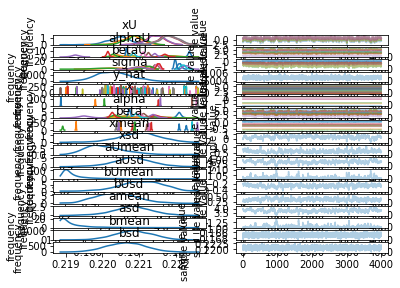

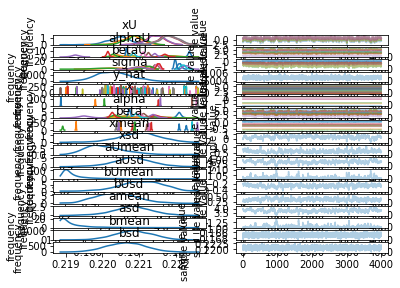

In [71]:
# THIS ONE running stephen's model on fake data

fit = pystan.stan(model_code=steph_code, data=fake_data, iter = 4000, chains=2)

la = fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)
print(fit)
fit.plot()

In [ ]:
# THIS ONE running stephen's model on real data w less iter and chain because time constraint

fit = pystan.stan(model_code=steph_code, data=steph_data, iter = 1000, chains=1)

la = fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)
print(fit)
fit.plot()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe43cfaaf97883bcebbd9029a9cf615f NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [72]:
dataframe = fit.to_dataframe(inc_warmup=False, diagnostics=False)
#print(dataframe.head(100))
i=1
k=1
x = []
alpha = []
beta = []
while i < total_players+1:
    
    x.append(np.average(dataframe[f'x[{i}]']))
    i = i+1
    
while k < total_holes+1:
    beta.append(np.average(dataframe[f'beta[{k}]']))
    alpha.append(np.average(dataframe[f'alpha[{k}]']))
    k = k+1
print(x)
print(alpha)
print(beta)

[-1.6175279625165275, -0.9600675704018868, -0.7881220871918365, 0.24120865284628015, 0.2795778302314998, 0.8848870590646254, 0.9663400697843177, 0.9937040081835282]
[5.712666781246673, 4.6931072801015645, 4.521491881273449, 4.646976071970192, 4.553866546048193, 4.134530577760479, 3.9608368355520125, 3.377997203884343, 3.3251854847724927, 3.7933764345929815, 3.500866694160255, 2.9544842378509006, 2.8599935333457336, 2.7434637287163905, 1.4912573090449104]
[0.09773565513112087, -0.5176810269783518, -0.592309758222508, -0.20261368541718058, 0.15967448180831037, -0.12266687918189845, -0.11105326678558115, -0.29298260227637574, -0.2744405951669492, 0.13029493723304517, 0.05774508063909592, -0.2674979572856539, -0.19005624827217382, -0.09769500356993098, -0.2797710041497368]


In [73]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

pRMSE = sqrt(mean_squared_error(pDF['x_std'], x))			# taking RMSE from predicted values compared to our "true values" set out in first file
print(f"Root mean squared error for the player average is {pRMSE}")
#print(pDF['x_std'])
hRMSE = sqrt(mean_squared_error(hDF['h_avg'], alpha))			# taking RMSE from predicted values compared to our "true values" set out in first file
print(f"Root mean squared error for the hole average is {hRMSE}")
#print(hDF['h_avg'])

dRMSE = sqrt(mean_squared_error(hDF['h_dsr'], beta))			# taking RMSE from predicted values compared to our "true values" set out in first file
print(f"Root mean squared error for the discrimination average is {dRMSE}")

Root mean squared error for the player average is 1.8187322680676927
Root mean squared error for the hole average is 0.4014322944309256
Root mean squared error for the discrimination average is 0.5579602410542516
